A result for dimension 20. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, vmap, einsum
from time import time
from hilbert_matrix import hilbert_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import math, os, sys
torch.manual_seed(0)

cpu


In [2]:
# dimension
D = 5

# domain width
L = 1.0

In [3]:
# rhs

om = 2.

c = -1.

def f(x):
    return (-om ** 2 + c) * (om * x).cos().sum()


# boundary condition
def g(x):
    return (om * x).cos().sum()


def u_true(x):
    return (om * x).cos().sum()

In [4]:
# path simulation time
T = 6. / np.sqrt(D)

# Total umber of paths
M_tot = 1000

# Batch size of each epoch
M = 1000

# number of grid points
N = 100

# number of grid points at the boundaries
N_bdry = 10000

# weight of boundary loss
c_boundary = 1.0

# number of collocation points for evaluating the integral
N_test = 10000

# number of training epochs
n_epoch = 10

In [5]:
# time step size
dt = T / N
dBt = math.sqrt(dt)

def sample_NDstdBM_paths(M: int, D: int, T: float, N: int):
    return torch.cumsum(
        torch.concat([
            torch.zeros(M, 1, D),
            torch.randn(M, N, D) * math.sqrt(T / N)
        ], dim=1), dim=1
    )


W_tot = sample_NDstdBM_paths(M_tot, D, T, N)

In [6]:
def mask_NDstdBM_paths(paths, L: float):
    oob = paths.abs().max(dim=2)[0].le(L).double()
    return oob.cummin(dim=1).values, oob.argmin(dim=1)


mask, exit_idx = mask_NDstdBM_paths(W_tot, L)
print(f"Boundary unreached rate: {mask[:, -1].sum().item() / M_tot * 100:.2f}%")

Boundary unreached rate: 0.00%


In [7]:
def sample_boundary_points(N_bdry: int, D: int, L: float):
    rand_u = torch.rand(N_bdry, D) - 0.5
    return rand_u / rand_u.abs().max(dim=1)[0].unsqueeze(dim=1) * L


X_bdry = sample_boundary_points(N_bdry, D, L)

In [8]:
# get u0 by Feynman-Kac formula
# u0 = (vmap(g)(torch.stack([W_tot[i, exit_idx[i], :] for i in range(M_tot)])) * (c * exit_idx * dt / 2).exp() - .5 * \
#      (f_val_tot * (torch.linspace(0, T, N+1) * c / 2).exp() * mask).sum(dim=1).mul(dt)).mean()
# u0.item()

In [9]:
time_cost = []
for D in range(100, 1001, 100):
    A = hilbert_matrix(D)
    W_tot = sample_NDstdBM_paths(M_tot, D, T, N)
    X_tot = einsum("ijk,kl->ijl", W_tot, A)
    mask, exit_idx = mask_NDstdBM_paths(W_tot, L)
    X_bdry = sample_boundary_points(N_bdry, D, L)
    u = nn.Sequential(nn.Linear(D, 100),
                      nn.Tanh(), # nn.GELU(approximate="tanh"),
                      nn.Linear(100, 100),
                      nn.GELU(approximate="tanh"),
                      nn.Linear(100, 1))

    X_test = torch.rand(N_test, D) * 2 * L - L

    optimizer = torch.optim.Adamax(u.parameters(), lr=.05, )

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    loss_rec = np.zeros(n_epoch + 1)
    l2_err_rec = np.zeros(n_epoch + 1)
    l2_norm_rec = np.zeros(n_epoch + 1)

    f_val_tot = vmap(vmap(f))(W_tot)
    g_val = vmap(g)(X_bdry)
    
    
    # get u0 by Feynman-Kac formula
    # u0 = (vmap(g)(torch.stack([W_tot[i, exit_idx[i], :] for i in range(M_tot)])) * (c * exit_idx * dt / 2).exp() - .5 * \
    #      (f_val_tot * (torch.linspace(0, T, N+1) * c / 2).exp() * mask).sum(dim=1).mul(dt)).mean()

    start_time = time()
    for i in range(n_epoch):
        batch_idx = torch.randint(0, M_tot, (M,))
        W = W_tot[batch_idx]
        X = X_tot[batch_idx]
        f_val = f_val_tot[batch_idx]
        u_val = vmap(u)(X).squeeze()
        u_val_bdry = u(X_bdry).squeeze()
        loss_mart = ((u_val[:, 1:] - u_val[:, :-1] - (f_val - c * u_val)[:, :-1] / 2. * dt)
                     * mask[batch_idx, :-1]).sum(axis=0).pow(2).sum() / T / M ** 2
        # X_bdry = sample_boundary_points(N_bdry, D, L)
        loss_bdry = (u(X_bdry).squeeze() - g_val).pow(2).sum() / N_bdry
        # loss_0 = (u(torch.zeros(D)) - D) ** 2
        # loss_0 = (u(torch.zeros(D)) - u0) ** 2
        loss = loss_mart + 5000. * loss_bdry     # + 10. * loss_0
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        u_test_val = u(X_test).squeeze()
        u_true_val = vmap(u_true)(X_test).squeeze()
        L2_loss = torch.sqrt((u_test_val - u_true_val).pow(2).sum() / N_test)
        L2_norm = torch.sqrt(u_test_val.pow(2).sum() / N_test)

        loss_rec[i] = loss.item()
        l2_err_rec[i] = L2_loss.item()
        l2_norm_rec[i] = L2_norm.item()

        if i % 100 == 0:
            scheduler.step()

        if i % 1 == 0 or i == n_epoch - 1:
            print(f"round {i}, loss={loss.item()}, L2 error={L2_loss.item()}, L2 norm={L2_norm.item()}")

    end_time = time()
    
    time_cost.append(end_time - start_time)

    print(f"Training finished in {end_time - start_time} seconds.")
    print("Now saving the results ... ", end="")
    torch.save(u.state_dict(), os.path.join(".", "the_network.pt"))
    np.savez("loss_and_err.npz", loss_rec=loss_rec, l2_err_rec=l2_err_rec)
    print("done.")
    print("Congratulations! Everything is done.")

round 0, loss=10085371.56802486, L2 error=44.442962646484375, L2 norm=1.3742318153381348
round 1, loss=9496779.178524487, L2 error=42.1994743347168, L2 norm=5.214327812194824
round 2, loss=8433028.223615076, L2 error=38.78986358642578, L2 norm=12.327590942382812
round 3, loss=6930124.026743301, L2 error=34.41460037231445, L2 norm=23.2023868560791
round 4, loss=5291341.295783963, L2 error=31.74884796142578, L2 norm=36.020511627197266
round 5, loss=4566595.97035326, L2 error=30.37066650390625, L2 norm=42.859466552734375
round 6, loss=4335539.519811621, L2 error=25.998638153076172, L2 norm=42.49616241455078
round 7, loss=3181500.9353188705, L2 error=18.941972732543945, L2 norm=39.825592041015625
round 8, loss=1648112.8985916881, L2 error=13.132521629333496, L2 norm=39.82291030883789
round 9, loss=797336.8762347911, L2 error=12.609307289123535, L2 norm=42.99184036254883
Training finished in 2.0690040588378906 seconds.
Now saving the results ... done.
Congratulations! Everything is done.
ro

In [10]:
"""
x_test = torch.linspace(-L, L, 100).unsqueeze(dim=1) * torch.ones(D)
u_test = u(x_test)
u_test_true = vmap(u_true)(x_test)
plt.plot(np.linspace(-L, L, 100).unsqueeze(dim=1) * , u_test.detach().numpy().flatten())
plt.plot(np.linspace(-L, L, 100), u_test_true.detach().numpy().flatten())
plt.show()
"""

'\nx_test = torch.linspace(-L, L, 100).unsqueeze(dim=1) * torch.ones(D)\nu_test = u(x_test)\nu_test_true = vmap(u_true)(x_test)\nplt.plot(np.linspace(-L, L, 100).unsqueeze(dim=1) * , u_test.detach().numpy().flatten())\nplt.plot(np.linspace(-L, L, 100), u_test_true.detach().numpy().flatten())\nplt.show()\n'

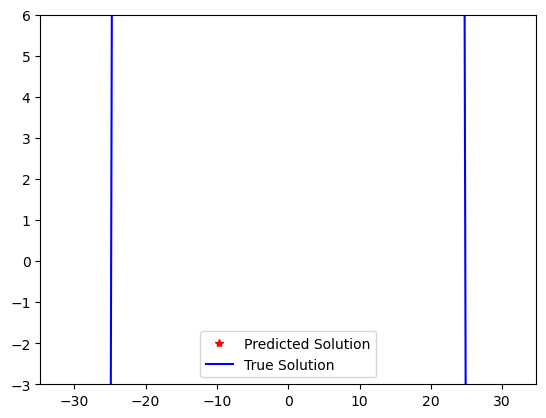

In [11]:
u.load_state_dict(torch.load("the_network.pt"))


x_test = torch.linspace(-L, L, 200).unsqueeze(dim=1) * torch.ones(D)
plt.plot(np.linspace(-np.sqrt(D) * L, np.sqrt(D) * L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "r*")
plt.plot(np.linspace(-np.sqrt(D) * L, np.sqrt(D) * L, 200), vmap(u_true)(x_test).detach().numpy(), "b")
plt.ylim(-3, 6)
plt.legend(["Predicted Solution", "True Solution"])
plt.savefig("20d_diag.png")
plt.show()

$$
u(x \mathbf{e}), x \in [-L, L]
$$
where
$$
\mathbf{e} = \frac{1}{\sqrt{D}} (1, 1, \cdots, 1)
$$

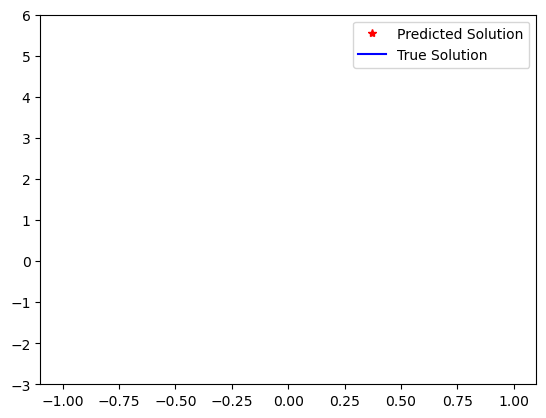

In [12]:
x_test = torch.linspace(-1, 1, 100).unsqueeze(dim=1) * (torch.tensor([0.] * (D-1) + [1.]))

plt.plot(np.linspace(-L, L, 100)[::4], u(x_test).squeeze().detach().numpy()[::4], "r*")
plt.plot(np.linspace(-L, L, 100), vmap(u_true)(x_test).detach().numpy(), "b")
plt.ylim(-3, 6)
plt.savefig("20d_axis.png")

plt.legend(["Predicted Solution", "True Solution"])

plt.show()

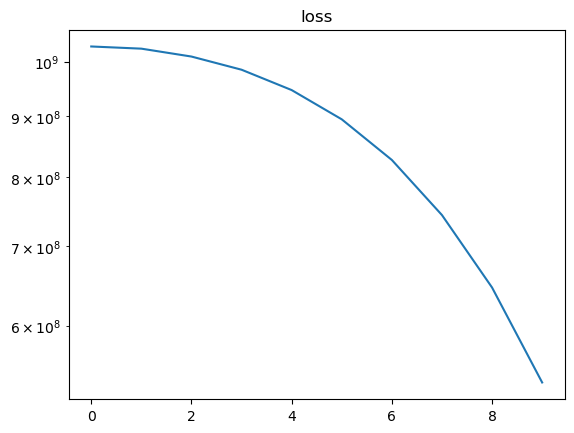

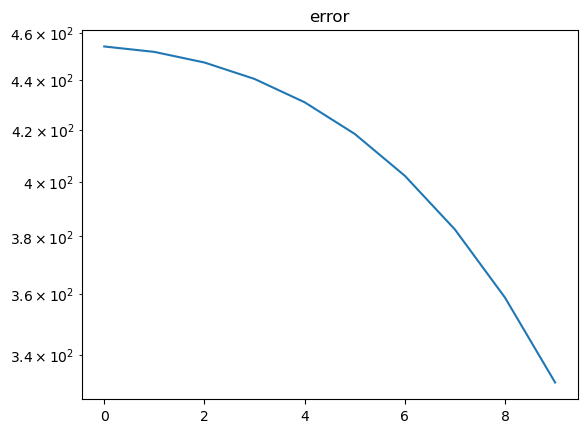

In [13]:
rec = np.load("loss_and_err.npz")
l2_err_rec = rec["l2_err_rec"]
loss_rec = rec["loss_rec"]

plt.semilogy(loss_rec[:-1])
plt.title("loss")
plt.show()

plt.semilogy(l2_err_rec[:-1])
plt.title("error")
plt.show()

In [14]:
time_cost

[2.0690040588378906,
 2.2594354152679443,
 1.865457534790039,
 2.916588544845581,
 2.0987887382507324,
 2.4021496772766113,
 2.562037467956543,
 2.7092478275299072,
 2.92331600189209,
 3.5783567428588867]

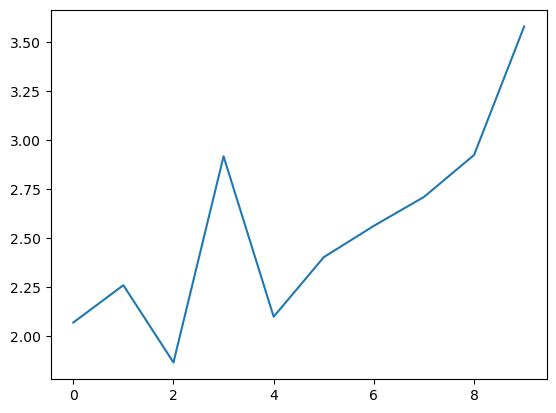

In [15]:
plt.plot(time_cost)

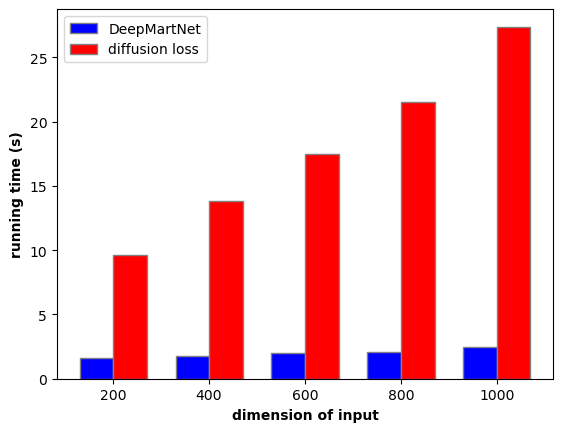

In [16]:
# Your datasets
dataset1 = [#2.1492230892181396,
 1.6476867198944092,
 #1.7551367282867432,
 1.7471692562103271,
 #2.7701101303100586,
 2.003566265106201,
 #3.261931896209717,
 2.102625846862793,
 #2.533445119857788,
 2.473068952560425]
dataset2 = [#6.267411470413208,
 9.614429950714111,
 #9.471572399139404,
 13.805604934692383,
 #13.59018349647522,
 17.444061517715454,
 #22.01487398147583,
 21.538599252700806,
 #16.127997875213623,
 27.373826026916504]

# Labels for the bars
labels = [str(x) for x in range(200, 1001, 200)]

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = range(len(dataset1))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, dataset1, color='b', width=bar_width, edgecolor='grey', label='DeepMartNet')
plt.bar(r2, dataset2, color='r', width=bar_width, edgecolor='grey', label='diffusion loss')

# Add labels to the bars
plt.xlabel('dimension of input', fontweight='bold')
plt.ylabel('running time (s)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(dataset1))], labels)

# Add a legend
plt.legend()

# Display the plot
plt.show()

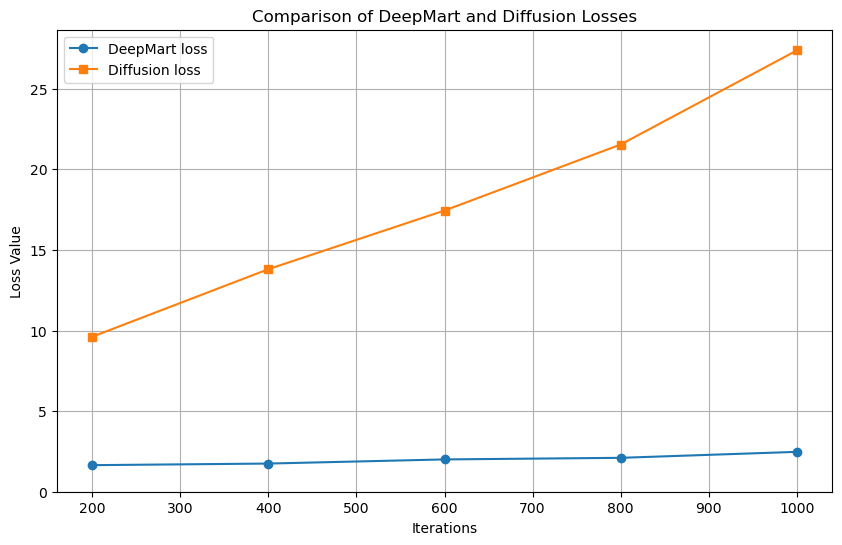

In [17]:
import matplotlib.pyplot as plt

# Data sets
dataset1 = [1.6476867198944092, 1.7471692562103271, 2.003566265106201, 2.102625846862793, 2.473068952560425]
dataset2 = [9.614429950714111, 13.805604934692383, 17.444061517715454, 21.538599252700806, 27.373826026916504]
x_values = [200, 400, 600, 800, 1000]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, dataset1, label='DeepMart loss', marker='o')
plt.plot(x_values, dataset2, label='Diffusion loss', marker='s')

# Add titles and labels
plt.title('Comparison of DeepMart and Diffusion Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.ylim(bottom=0)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
